In [1]:
# Import necessary libraries for data creation and analysis
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def create_sample_data():
    """
    Creates sample tables for healthcare facility enforcement data analysis.
    In practice, this would be real data from ASPEN and ELMS databases.
    """
    # Create facilities table
    duckdb.sql("""
        CREATE TABLE facilities AS 
        SELECT * FROM (
            VALUES 
            (1, 'Valley Care', 'SNF', 'Active'),
            (2, 'Sunshine Health', 'SNF', 'Active'),
            (3, 'Harbor Hospital', 'Hospital', 'Active'),
            (4, 'Mountain View Care', 'SNF', 'Inactive')
        ) AS t (facility_id, facility_name, facility_type, status)
    """)

    # Create enforcement actions table
    duckdb.sql("""
        CREATE TABLE enforcement_actions AS
        SELECT * FROM (
            VALUES 
            (1, 1, '2024-01-15', 'Complaint Investigation', 'Substantiated'),
            (2, 1, '2024-02-01', 'Follow-up Visit', 'Resolved'),
            (3, 2, '2024-01-20', 'Annual Survey', 'Deficiency Found'),
            (4, 2, '2024-02-15', 'Complaint Investigation', 'Unsubstantiated'),
            (5, 3, '2024-01-10', 'Complaint Investigation', 'Substantiated'),
            (6, 3, '2024-02-20', 'Follow-up Visit', 'Pending')
        ) AS t (action_id, facility_id, action_date, action_type, outcome)
    """)

    facilities = duckdb.sql("SELECT * FROM facilities").df()
    enforcement_actions = duckdb.sql("SELECT * FROM enforcement_actions").df()
    
    return facilities, enforcement_actions

In [3]:
# Execute data creation function
facilities, enforcement = create_sample_data()

In [4]:
# View the tables before analysis done on top of them
facilities

,facility_id,facility_name,facility_type,status
0,1,Valley Care,SNF,Active
1,2,Sunshine Health,SNF,Active
2,3,Harbor Hospital,Hospital,Active
3,4,Mountain View Care,SNF,Inactive


In [5]:
enforcement

,action_id,facility_id,action_date,action_type,outcome
0,1,1,2024-01-15,Complaint Investigation,Substantiated
1,2,1,2024-02-01,Follow-up Visit,Resolved
2,3,2,2024-01-20,Annual Survey,Deficiency Found
3,4,2,2024-02-15,Complaint Investigation,Unsubstantiated
4,5,3,2024-01-10,Complaint Investigation,Substantiated
5,6,3,2024-02-20,Follow-up Visit,Pending


In [6]:
def get_enforcement_metrics():
    """
    Analyzes enforcement actions and facility compliance patterns.
    Returns detailed data and summary metrics.
    """
    # Execute SQL query to analyze enforcement patterns
    detailed_data = duckdb.sql("""
        WITH EnforcementSummary AS (
            SELECT 
                f.facility_id,
                f.facility_name,
                f.facility_type,
                COUNT(ea.action_id) as total_actions,
                SUM(CASE WHEN ea.outcome = 'Substantiated' THEN 1 ELSE 0 END) as substantiated_complaints,
                SUM(CASE WHEN ea.action_type = 'Follow-up Visit' THEN 1 ELSE 0 END) as followup_visits
            FROM facilities f
            LEFT JOIN enforcement_actions ea ON f.facility_id = ea.facility_id
            WHERE f.status = 'Active'
            GROUP BY f.facility_id, f.facility_name, f.facility_type
        )
        SELECT 
            *,
            CAST(substantiated_complaints AS FLOAT) / NULLIF(total_actions, 0) as substantiation_rate
        FROM EnforcementSummary
        ORDER BY total_actions DESC
    """).df()

    # Calculate summary statistics
    summary_metrics = {
        'total_facilities': len(detailed_data),
        'avg_actions_per_facility': detailed_data['total_actions'].mean(),
        'total_substantiated': detailed_data['substantiated_complaints'].sum(),
        'avg_substantiation_rate': detailed_data['substantiation_rate'].mean()
    }

    return detailed_data, summary_metrics

In [7]:
# Execute enforcement actions and facility compliance patterns function
detailed_data, summary_metrics = get_enforcement_metrics()

In [8]:
detailed_data

,facility_id,facility_name,facility_type,total_actions,substantiated_complaints,followup_visits,substantiation_rate
0,1,Valley Care,SNF,2,1.0,1.0,0.5
1,3,Harbor Hospital,Hospital,2,1.0,1.0,0.5
2,2,Sunshine Health,SNF,2,0.0,0.0,0.0


In [9]:
def create_enforcement_visualizations(data):
    """
    Creates visualizations of enforcement metrics using matplotlib.
    Uses styling and proper axis and legend placement.
    """
    # Use appropriate seaborn style name
    plt.style.use('seaborn-v0_8')
    
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot 1: Comparison of Actions by Facility
    bar_width = 0.35
    facilities = data['facility_name']
    x = np.arange(len(facilities))  # Use numpy for consistent spacing
    
    ax1.bar(x, data['total_actions'], bar_width, label='Total Actions', color='skyblue')
    ax1.bar(x + bar_width, data['substantiated_complaints'], 
            bar_width, label='Substantiated Complaints', color='orange')
    
    ax1.set_ylabel('Number of Actions')
    ax1.set_title('Enforcement Actions by Facility')
    ax1.set_xticks(x + bar_width/2)
    ax1.set_xticklabels(facilities, rotation=45, ha='right')
    # Move legend to the upper right corner outside the plot
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: Substantiation Rates
    colors = ['lightgreen' if rate > 0.4 else 'lightcoral' for rate in data['substantiation_rate']]
    
    # Create bar plot with explicit x positions
    x2 = np.arange(len(facilities))
    ax2.bar(x2, data['substantiation_rate'], color=colors)
    ax2.set_ylabel('Substantiation Rate')
    ax2.set_title('Substantiation Rate by Facility')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(facilities, rotation=45, ha='right')
    ax2.axhline(y=data['substantiation_rate'].mean(), color='red', linestyle='--', 
                label='Average Rate')
    # Move legend to the upper right corner outside the plot
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Format y-axis as percentage
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Adjust layout to prevent label cutoff and accommodate legends
    plt.tight_layout()
    
    # Add extra space on the right for the legends
    plt.subplots_adjust(right=0.85)
    
    # Display the plots
    plt.show()

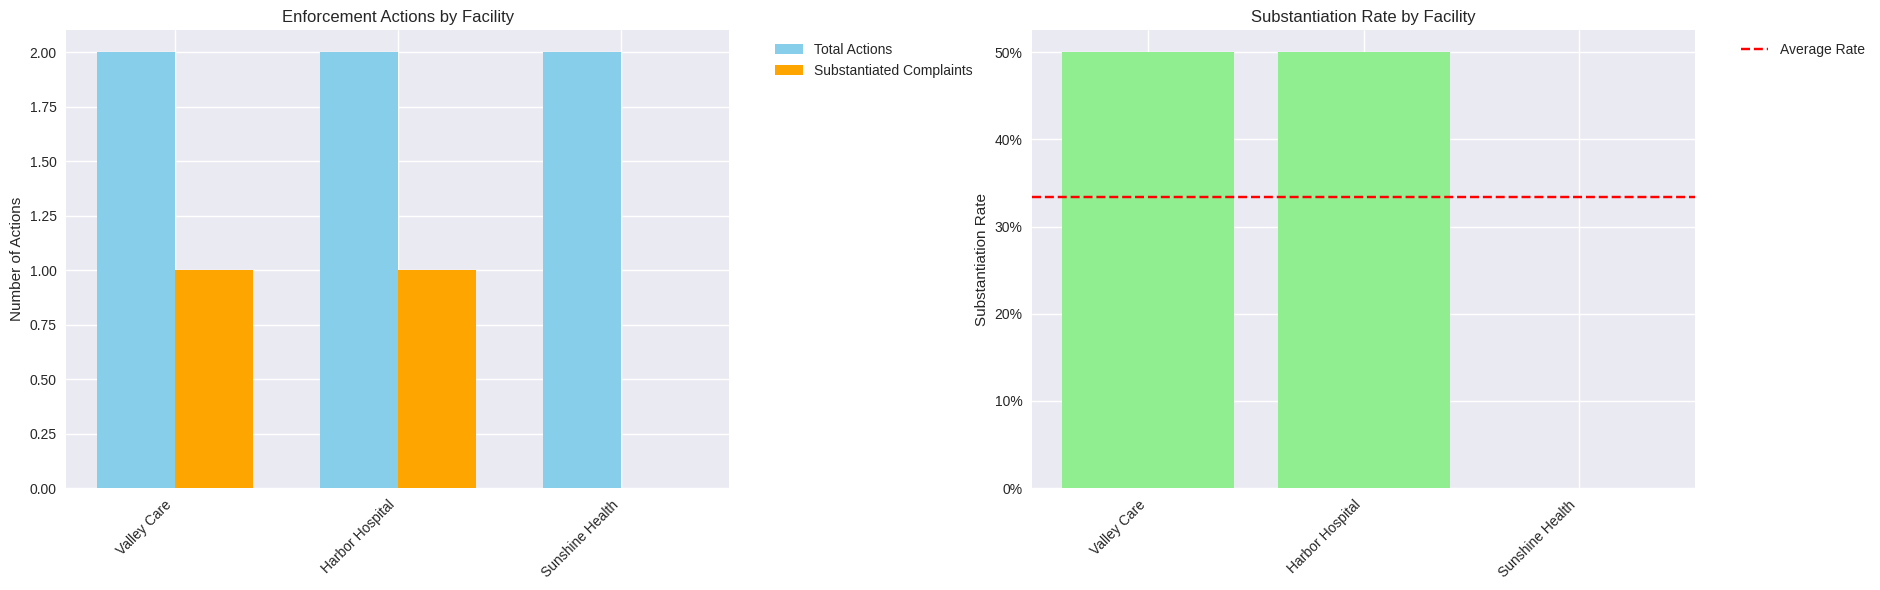

In [10]:
# Get a quick visual of facility metrics
create_enforcement_visualizations(detailed_data)

In [11]:
def generate_report(data, metrics):
    """
    Generates a formatted report of enforcement findings.
    """
    report = f"""Enforcement Analysis Report
------------------------
Summary Metrics:
- Total Active Facilities: {metrics['total_facilities']}
- Average Actions per Facility: {metrics['avg_actions_per_facility']:.2f}
- Total Substantiated Complaints: {metrics['total_substantiated']}
- Average Substantiation Rate: {metrics['avg_substantiation_rate']:.2%}

Detailed Facility Analysis:
"""
    
    for _, row in data.iterrows():
        report += f"\n{row['facility_name']} ({row['facility_type']})"
        report += f"\n  - Total Actions: {row['total_actions']}"
        report += f"\n  - Substantiated Complaints: {row['substantiated_complaints']}"
        report += f"\n  - Follow-up Visits: {row['followup_visits']}"
        report += f"\n  - Substantiation Rate: {row['substantiation_rate']:.2%}\n"
    
    return report

In [12]:
# Execute summary report
report = generate_report(detailed_data, summary_metrics)
print(report)

Enforcement Analysis Report
------------------------
Summary Metrics:
- Total Active Facilities: 3
- Average Actions per Facility: 2.00
- Total Substantiated Complaints: 2.0
- Average Substantiation Rate: 33.33%

Detailed Facility Analysis:

Valley Care (SNF)
  - Total Actions: 2
  - Substantiated Complaints: 1.0
  - Follow-up Visits: 1.0
  - Substantiation Rate: 50.00%

Harbor Hospital (Hospital)
  - Total Actions: 2
  - Substantiated Complaints: 1.0
  - Follow-up Visits: 1.0
  - Substantiation Rate: 50.00%

Sunshine Health (SNF)
  - Total Actions: 2
  - Substantiated Complaints: 0.0
  - Follow-up Visits: 0.0
  - Substantiation Rate: 0.00%

